<a href="https://colab.research.google.com/github/arina19-2000/unimi/blob/main/ABSA/born_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!pip install datasets
from datasets import load_dataset
ds = load_dataset("jordiclive/FABSA")
print(ds)


DatasetDict({
    train: Dataset({
        features: ['id', 'org_index', 'data_source', 'industry', 'text', 'labels', 'label_codes'],
        num_rows: 7930
    })
    validation: Dataset({
        features: ['id', 'org_index', 'data_source', 'industry', 'text', 'labels', 'label_codes'],
        num_rows: 1057
    })
    test: Dataset({
        features: ['id', 'org_index', 'data_source', 'industry', 'text', 'labels', 'label_codes'],
        num_rows: 1587
    })
})


In [74]:
import pandas as pd
import numpy as np

dff = pd.DataFrame(ds['train'])
dff.head()

,id,org_index,data_source,industry,text,labels,label_codes
0,301972057,600,Trustpilot,Price Comparison,My experience is only around the Parking forum...,"[[Staff support: Attitude of staff, negative],...","['staff-support.attitude-of-staff.-1', 'compan..."
1,301982453,514,Google Play,Banking,"I love it so handy, plus I hate my bank so it ...","[[Company brand: General satisfaction, positiv...","['company-brand.general-satisfaction.1', 'comp..."
2,301980653,369,Google Play,Ride Hailing,Sometimes it takes,"[[Company brand: General satisfaction, negative]]",['company-brand.general-satisfaction.-1']
3,301979991,727,Apple Store,Fashion,This is the worst app I ordered my sneakers 2/...,"[[Logistics rides: Speed, negative], [Online e...","['logistics-rides.speed.-1', 'online-experienc..."
4,301984330,549,Google Play,Travel Booking,So easy & loads of info !,"[[Company brand: General satisfaction, positive]]",['company-brand.general-satisfaction.1']


In [75]:
dft = pd.DataFrame(ds['test'])

In [76]:
dff.shape

(7930, 7)

In [77]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7930 entries, 0 to 7929
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7930 non-null   int64 
 1   org_index    7930 non-null   int64 
 2   data_source  7930 non-null   object
 3   industry     7930 non-null   object
 4   text         7930 non-null   object
 5   labels       7930 non-null   object
 6   label_codes  7930 non-null   object
dtypes: int64(2), object(5)
memory usage: 433.8+ KB


In [78]:
dft.shape

(1587, 7)

In [79]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1587 non-null   int64 
 1   org_index    1587 non-null   int64 
 2   data_source  1587 non-null   object
 3   industry     1587 non-null   object
 4   text         1587 non-null   object
 5   labels       1587 non-null   object
 6   label_codes  1587 non-null   object
dtypes: int64(2), object(5)
memory usage: 86.9+ KB


In [80]:
dff['data_source'].value_counts()

,count
data_source,
Google Play,4612
Apple Store,1870
Trustpilot,1448


In [81]:
dft['data_source'].value_counts()

,count
data_source,
Google Play,910
Apple Store,389
Trustpilot,288


In [82]:
dff['industry'].value_counts()

,count
industry,
Fashion,2161
Price Comparison,1157
Groceries,1021
Trading,1021
Travel Booking,973
Banking,913
Ride Hailing,383
Information Technology,141
Consulting,81


In [83]:
dft['industry'].value_counts()

,count
industry,
Fashion,419
Price Comparison,239
Travel Booking,211
Groceries,206
Trading,195
Banking,189
Ride Hailing,83
Information Technology,23
Consulting,13


## Preprocessing

In [84]:
import ast
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag,word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean(self, text):
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text

    def get_wordnet_pos(self, tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def preprocess_text(self, text):
        text = self.clean(text)
        words = word_tokenize(text)
        pos_tagged = pos_tag(words)
        tokens = []

        for word, tag in pos_tagged:
            wordnet_pos = self.get_wordnet_pos(tag)
            if word.lower() not in self.stop_words:
                if word.lower() == "not" and tag == 'PART':
                    tokens.append(word.lower())
                else:
                    lemma = self.lemmatizer.lemmatize(word.lower(), wordnet_pos)
                    if tag in {'JJ', 'RB', 'NN', 'VB', 'PRP', 'NNS', 'JJR', 'JJS', 'VBZ'}:
                        tokens.append(lemma)

        return ' '.join(tokens)

    def preprocess_text_column(self):
        self.df['clean_text'] = self.df['text'].apply(self.preprocess_text)

    def aspects(self, label_codes):
        first_elements = [label.split('.')[0].replace('-', ' ').strip() for label in label_codes]
        return first_elements

    def unique_aspects(self, label_codes):
        first_elements = [label.split('.')[0].replace('-', ' ').strip() for label in label_codes]
        unique_elements = list(set(first_elements))
        return unique_elements

    def process_label_codes(self):
        self.df['label_codes'] = self.df['label_codes'].dropna().apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    def split_label_sentiment(self, label_code):
        if '.' in label_code:
            label, sentiment = label_code.rsplit('.', 1)
            return label.replace("-", " "), sentiment
        return label_code, None

    def extract_sentiments(self, label_codes):
        label_sentiments = [self.split_label_sentiment(label) for label in label_codes]
        sentiments = [int(sentiment) if sentiment in ['-1', '0', '1'] else None for _, sentiment in label_sentiments]
        return sentiments

    def assign_positive(self, sentiments):
        sentiment_sum = sum([s for s in sentiments if s is not None])
        return 1 if sentiment_sum >= 0 else 0

    def create_aspect_columns(self):
        self.df['aspects'] = self.df['label_codes'].apply(self.aspects)
        self.df['unique_aspects'] = self.df['label_codes'].apply(self.unique_aspects)

    def create_sentiment_columns(self):
        self.df['sentiments'] = self.df['label_codes'].apply(lambda x: self.extract_sentiments(x))
        self.df['positive'] = self.df['sentiments'].apply(self.assign_positive)

    def create_true_label_map(self, row):
        label_codes = row['label_codes']
        true_label_map = {}
        for label_code in label_codes:
            parts = label_code.split('.')
            aspect = parts[0].replace("-", " ")
            sentiment = int(parts[-1])
            true_sentiment = 0 if sentiment == -1 else 1
            true_label_map[aspect] = true_sentiment
        return true_label_map

    def create_true_label_column(self):
        self.df['true_label'] = self.df.apply(self.create_true_label_map, axis=1)

    def create_dummy_variables(self):
        dummies = pd.get_dummies(self.df['unique_aspects'].apply(pd.Series).stack()).groupby(level=0).sum()
        self.df = pd.concat([self.df, dummies], axis=1)

    def process(self):
        self.preprocess_text_column()
        self.process_label_codes()
        self.create_aspect_columns()
        self.create_sentiment_columns()
        self.create_true_label_column()
        self.create_dummy_variables()
        return self.df



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [85]:
processor_train = DataProcessor(dff)
dftrain = processor_train.process()

In [86]:
processor_test = DataProcessor(dft)
dftest = processor_test.process()

dftest.head()

,id,org_index,data_source,industry,text,labels,label_codes,clean_text,aspects,unique_aspects,sentiments,positive,true_label,account management,company brand,logistics rides,online experience,purchase booking experience,staff support,value
0,301982094,514,Google Play,Banking,Very useful and easy.,"[[Purchase booking experience: Ease of use, po...",[purchase-booking-experience.ease-of-use.1],useful easy,[purchase booking experience],[purchase booking experience],[1],1,{'purchase booking experience': 1},0,0,0,0,1,0,0
1,301981085,369,Google Play,Ride Hailing,easy to use.gud response from customer care se...,"[[Staff support: Attitude of staff, positive],...","[staff-support.attitude-of-staff.1, online-exp...",easy usegud response customer care section tym...,"[staff support, online experience, purchase bo...","[staff support, purchase booking experience, v...","[1, -1, 1, -1]",1,"{'staff support': 1, 'online experience': 0, '...",0,0,0,1,1,1,1
2,301986508,685,Google Play,Trading,money 😁,"[[Company brand: General satisfaction, positive]]",[company-brand.general-satisfaction.1],money,[company brand],[company brand],[1],1,{'company brand': 1},0,1,0,0,0,0,0
3,301981875,514,Google Play,Banking,Great facility,"[[Company brand: General satisfaction, positive]]",[company-brand.general-satisfaction.1],facility,[company brand],[company brand],[1],1,{'company brand': 1},0,1,0,0,0,0,0
4,301977341,411,Apple Store,Groceries,"Love doing my ORG411 shop with the app, never ...","[[Purchase booking experience: Ease of use, po...","[purchase-booking-experience.ease-of-use.1, on...",shop app never issue,"[purchase booking experience, online experience]","[online experience, purchase booking experience]","[1, 1]",1,"{'purchase booking experience': 1, 'online exp...",0,0,0,1,1,0,0


## Vectorization and Test-train split

In [87]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.95,
    min_df=10,
    ngram_range=(1, 3)
)

In [88]:
X_train = vectorizer.fit_transform(dftrain["clean_text"])
y_train = dftrain['positive'].values
X_test = vectorizer.transform(dftest["clean_text"])
y_test = dftest['positive'].values

## Models

In [89]:
!pip install bornrule
from bornrule import BornClassifier
from sklearn.metrics import classification_report, f1_score,ConfusionMatrixDisplay,confusion_matrix

              precision    recall  f1-score   support

           0       0.65      0.36      0.46       449
           1       0.79      0.92      0.85      1138

    accuracy                           0.76      1587
   macro avg       0.72      0.64      0.66      1587
weighted avg       0.75      0.76      0.74      1587



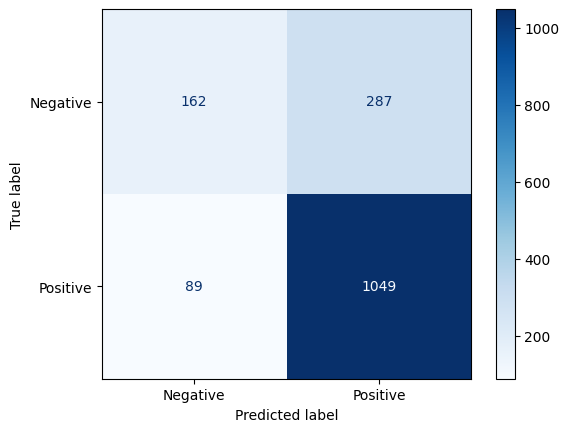

In [90]:
#Baseline
born_benchmark = BornClassifier(a=1, b=0, h=0)
born_benchmark.fit(X_train, y_train)
y_pred_bm = born_benchmark.predict(X_test)
print(classification_report(y_test, y_pred_bm, zero_division=0))
cm = confusion_matrix(y_test, y_pred_bm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Positive'])
disp.plot(cmap='Blues', values_format='d')

              precision    recall  f1-score   support

           0       0.64      0.79      0.71       449
           1       0.91      0.83      0.87      1138

    accuracy                           0.82      1587
   macro avg       0.78      0.81      0.79      1587
weighted avg       0.83      0.82      0.82      1587



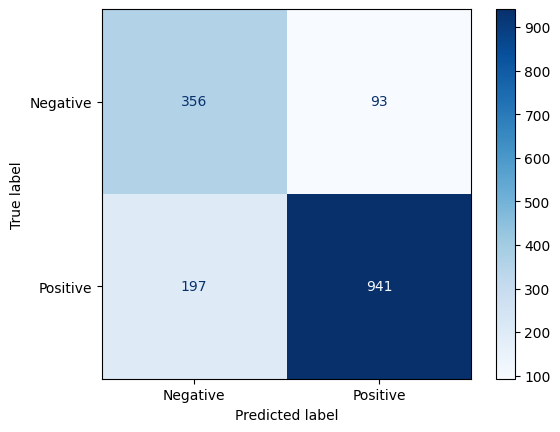

In [91]:
#Adjusted Born
bc = BornClassifier(a=0.5, b=1, h=1)
bc.fit(X_train, y_train)
y_pred_bc = bc.predict(X_test)
print(classification_report(y_test, y_pred_bc, zero_division=0))
cm = confusion_matrix(y_test, y_pred_bc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Positive'])
disp.plot(cmap='Blues', values_format='d')

In [92]:
# SVM
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred_svm, zero_division=0))

# Logreg
from sklearn.linear_model import LogisticRegression
log_reg_classifier = LogisticRegression(max_iter=300,  multi_class='multinomial')

log_reg_classifier.fit(X_train, y_train)

y_pred_log_reg = log_reg_classifier.predict(X_test)
print(classification_report(y_test, y_pred_log_reg, zero_division=0))

              precision    recall  f1-score   support

           0       0.79      0.63      0.70       449
           1       0.86      0.93      0.90      1138

    accuracy                           0.85      1587
   macro avg       0.83      0.78      0.80      1587
weighted avg       0.84      0.85      0.84      1587

              precision    recall  f1-score   support

           0       0.81      0.62      0.70       449
           1       0.86      0.94      0.90      1138

    accuracy                           0.85      1587
   macro avg       0.84      0.78      0.80      1587
weighted avg       0.85      0.85      0.84      1587



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


## 2. Explain the results

In [93]:
explanation = bc.explain()
print(explanation)

  (0, 0)	0.00016086261165765422
  (0, 1)	0.00014387294940084187
  (1, 0)	0.0066343559620978725
  (1, 1)	0.004409022012102314
  (2, 0)	0.004698083969590757
  (2, 1)	0.009807833709889573
  (3, 0)	0.0010332422206624653
  (3, 1)	0.0012807426316799695
  (4, 0)	0.011492573116677498
  (4, 1)	0.005493282287930081
  (5, 0)	0.0009386536659196453
  (5, 1)	0.0007974691777844124
  (6, 0)	3.9070415466388855e-05
  (6, 1)	3.693983714445948e-05
  (7, 0)	6.041007992529039e-06
  (7, 1)	5.98386653966217e-06
  (8, 0)	0.003377886519028326
  (8, 1)	0.015283528599145342
  (9, 0)	0.006558079526190394
  (9, 1)	0.025884687564888487
  (10, 0)	0.0001839978879655113
  (10, 1)	0.0002112826980836645
  (11, 0)	0.008929991753023371
  (11, 1)	0.0037777543244165083
  (12, 0)	0.012240221329792637
  :	:
  (971, 1)	0.003725234704891449
  (972, 0)	0.004161721493809981
  (972, 1)	0.01057091992451961
  (973, 0)	0.0009120986232365519
  (973, 1)	0.0011839080400872163
  (974, 0)	0.00034911275405238607
  (974, 1)	0.000307123167636

In [94]:
from scipy.sparse import csr_matrix

explanation_df = pd.DataFrame(csr_matrix(explanation).todense(), columns=["Negative", "Positive"])
tokens = vectorizer.get_feature_names_out()
explanation_df["Tokens"] = tokens
explanation_df.head(20)

,Negative,Positive,Tokens
0,0.000161,0.000144,ability
1,0.006634,0.004409,able
2,0.004698,0.009808,abroad
3,0.001033,0.001281,absolutely
4,0.011493,0.005493,accept
5,0.000939,0.000797,access
6,0.000039,0.000037,accommodation
7,0.000006,0.000006,account
8,0.003378,0.015284,account app
9,0.006558,0.025885,accurate


In [95]:
explanation_df = explanation_df[(explanation_df["Negative"]!=0) | (explanation_df["Positive"]!=0)]
top_negatives = explanation_df.sort_values(by="Negative", ascending=False).head(10)
top_positives = explanation_df.sort_values(by="Positive", ascending=False).head(10)

print("Top Negative Tokens:")
print(top_negatives[["Tokens", "Negative"]])

print("\nTop Positive Tokens:")
print(top_positives[["Tokens", "Positive"]])

Top Negative Tokens:
       Tokens  Negative
77        bad  0.067333
861  terrible  0.063347
302     error  0.053989
292     email  0.053177
205     crash  0.049786
968      wont  0.047488
762    screen  0.047328
846   support  0.047087
130      cart  0.046627
265    driver  0.044738

Top Positive Tokens:
        Tokens  Positive
271       easy  0.144210
531       love  0.100057
282   easy use  0.085271
94        best  0.082710
337       fast  0.082075
308  excellent  0.075061
433    helpful  0.070610
409      great  0.062865
106  brilliant  0.055545
532   love app  0.055152


## 3. Aspect prediction

In [96]:
from sklearn.multiclass import OneVsRestClassifier
from scipy.sparse import csr_matrix

class AspectModelTrainer2:
    def __init__(self, dftrain, dftest, X_train, X_test, vectorizer, BornClassifier):
        self.aspects = ['account management', 'company brand', 'logistics rides', 'online experience',
                        'purchase booking experience', 'staff support', 'value']
        self.dftrain = dftrain
        self.dftest = dftest
        self.X_train = X_train
        self.X_test = X_test
        self.vectorizer = vectorizer
        self.BornClassifier = BornClassifier
        self.model = None
        self.aspect_keywords = {}

    def print_aspect_counts(self):
        for aspect_column in self.aspects:
            count = self.dftrain[aspect_column].sum()
            print(f"Count for {aspect_column}: {count}")

    def prepare_data(self):
        X_dummies = self.dftrain[self.aspects]
        X_traina_ = pd.concat([pd.DataFrame(self.X_train.toarray()), X_dummies.reset_index(drop=True)], axis=1)
        X_traina = X_traina_.iloc[:, :-7]
        y_traina = X_traina_.iloc[:, -7:].values

        X_dummies_t = self.dftest[self.aspects]
        X_testa_ = pd.concat([pd.DataFrame(self.X_test.toarray()), X_dummies_t.reset_index(drop=True)], axis=1)
        X_testa = X_testa_.iloc[:, :-7]
        y_testa = X_testa_.iloc[:, -7:].values

        return X_traina, y_traina, X_testa, y_testa

    def train_model(self, X_traina, y_traina):
        self.model = OneVsRestClassifier(self.BornClassifier(a=0.5, b=1, h=1))
        self.model.fit(X_traina, y_traina)
        print("One-vs-Rest Model trained successfully.")

    def predict(self, X_testa):
        y_preda = self.model.predict(X_testa)
        return y_preda

    def evaluate(self, y_testa, y_preda):
        print("Evaluation Report:")
        print(classification_report(y_testa, y_preda, zero_division=0))

    def explain_models(self):
        tokens = self.vectorizer.get_feature_names_out()
        final_explanation_df = pd.DataFrame({'Tokens': tokens})

        print("Starting model explanation...")

        for i, estimator in enumerate(self.model.estimators_):
            explanation = estimator.explain()

            if explanation is not None:
                explanation_df = pd.DataFrame(csr_matrix(explanation).todense(),
                                              columns=[f'{self.aspects[i]}_no', f'{self.aspects[i]}_yes'])
                explanation_df["Tokens"] = tokens
                final_explanation_df = final_explanation_df.merge(explanation_df, on='Tokens', how='outer')

        print(final_explanation_df.head())
        return final_explanation_df

    def print_top_tokens(self, final_explanation_df):
        for aspect in self.aspects:
            yes_column = f'{aspect}_yes'
            no_column = f'{aspect}_no'

            if yes_column in final_explanation_df.columns:
                top_yes_tokens = final_explanation_df[['Tokens', yes_column]].sort_values(by=yes_column, ascending=False).head(10)
                print(f"Top 10 Tokens for Aspect: {aspect}")
                print(top_yes_tokens)

    def collect_aspect_keywords(self, final_explanation_df):
        for aspect in self.aspects:
            yes_column = f'{aspect}_yes'
            if yes_column in final_explanation_df.columns:
                top_yes_tokens = final_explanation_df[['Tokens', yes_column]].sort_values(by=yes_column, ascending=False).head(50)
                self.aspect_keywords[aspect] = top_yes_tokens['Tokens'].tolist()

        print(self.aspect_keywords)

    def run(self):
        self.print_aspect_counts()

        # Prepare then predict
        X_traina, y_traina, X_testa, y_testa = self.prepare_data()

        self.train_model(X_traina, y_traina)

        y_preda = self.predict(X_testa)
        self.evaluate(y_testa, y_preda)

        final_explanation_df = self.explain_models()

        self.print_top_tokens(final_explanation_df)
        self.collect_aspect_keywords(final_explanation_df)
        return self.aspect_keywords


In [97]:
trainer2 = AspectModelTrainer2(dftrain, dftest, X_train, X_test, vectorizer, BornClassifier)
aspect_keywords = trainer2.run()

Count for account management: 473
Count for company brand: 3427
Count for logistics rides: 1002
Count for online experience: 3600
Count for purchase booking experience: 2364
Count for staff support: 1171
Count for value: 1374
One-vs-Rest Model trained successfully.
Evaluation Report:
              precision    recall  f1-score   support

           0       0.30      0.86      0.44        79
           1       0.67      0.65      0.66       692
           2       0.41      0.84      0.55       189
           3       0.83      0.83      0.83       724
           4       0.67      0.83      0.74       503
           5       0.53      0.85      0.65       224
           6       0.57      0.82      0.67       288

   micro avg       0.62      0.79      0.69      2699
   macro avg       0.57      0.81      0.65      2699
weighted avg       0.66      0.79      0.71      2699
 samples avg       0.66      0.80      0.68      2699

Starting model explanation...
       Tokens  account management_

In [98]:
final_explanation_df = trainer2.explain_models()
final_explanation_df.shape

Starting model explanation...
       Tokens  account management_no  account management_yes  \
0     ability               0.006343                0.016394   
1        able               0.000064                0.000067   
2      abroad               0.013074                0.005015   
3  absolutely               0.032514                0.004986   
4      accept               0.011037                0.034025   

   company brand_no  company brand_yes  logistics rides_no  \
0          0.007072           0.003185            0.001100   
1          0.000070           0.000073            0.002998   
2          0.002300           0.003373            0.003240   
3          0.004875           0.008235            0.026005   
4          0.002268           0.001606            0.000001   

   logistics rides_yes  online experience_no  online experience_yes  \
0             0.000811              0.004068               0.012129   
1             0.002216              0.000911               0.001085   

(984, 15)

## 4. Associate aspects to portions of text

In [99]:
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

class TextAspectMapper:
    def __init__(self, df, aspect_keywords, vectorizer):
        self.df = df
        self.aspect_keywords = aspect_keywords
        self.vectorizer = vectorizer

    def associate_aspects_to_text(self, row):
        text = row['clean_text']
        aspects = row['aspects'] if row['aspects'] else []
        aspect_text_map = defaultdict(list)

        aspect_counts = defaultdict(int)
        for aspect in aspects:
            aspect_counts[aspect] += 1

        for aspect, count in aspect_counts.items():
            if count > 1 or len(aspects) == 1:
                aspect_text_map[aspect].append(text)
            else:
                keywords = self.aspect_keywords.get(aspect, [])
                if any(re.search(rf'\b{re.escape(keyword.lower())}\b', text.lower(), re.IGNORECASE) for keyword in keywords):
                    aspect_text_map[aspect].append(text)

        return aspect_text_map

    def create_true_label_map(self, row):
        label_codes = row['label_codes']
        true_label_map = {}

        for label_code in label_codes:
            parts = label_code.split('.')
            aspect = parts[0]
            sentiment = int(parts[-1])

            true_sentiment = 0 if sentiment == -1 else 1

            true_label_map[aspect] = true_sentiment

        return true_label_map

    def process(self):
        # Apply aspect mapping
        self.df.loc[:, 'aspect_text_map'] = self.df.apply(lambda row: self.associate_aspects_to_text(row), axis=1)

        # Filter out rows with empty aspect_text_map
        self.df = self.df[self.df['aspect_text_map'].apply(lambda x: x != {} and x is not None)]

        texts = [text for aspect_text_map in self.df['aspect_text_map'] for text_list in aspect_text_map.values() for text in text_list]
        X = self.vectorizer.transform(texts)

        return X, texts

    def update_predictions(self, predictions, texts):
        text_to_prediction = dict(zip(texts, predictions))
        self.df.loc[:, 'aspect_sentiment_map'] = self.df['aspect_text_map'].apply(lambda x: self.create_aspect_sentiment_mapping(x, text_to_prediction))

    def create_aspect_sentiment_mapping(self, aspect_text_map, text_to_prediction):
        aspect_sentiment_map = {}
        for aspect, texts in aspect_text_map.items():
            sentiment_list = [text_to_prediction.get(text, 'None') for text in texts]

            if len(sentiment_list) > 0:
                aspect_sentiment_map[aspect] = sentiment_list[0]
            else:
                aspect_sentiment_map[aspect] = 'None'

        return aspect_sentiment_map

    def apply_true_labels(self):
        self.df.loc[:, 'true_label'] = self.df.apply(lambda row: self.create_true_label_map(row), axis=1)

    def apply_sentiment_mapping(self):
        self.apply_true_labels()
        return self.df

In [100]:
test = TextAspectMapper(dftest, aspect_keywords, vectorizer)

X, texts = test.process()
predictions = bc.predict(X)

In [101]:
def associate_aspects_to_text(row, aspect_keywords):
    text = row['clean_text']
    aspects = row['aspects'] if row['aspects'] else []
    aspect_text_map = defaultdict(list)

    aspect_counts = defaultdict(int)
    for aspect in aspects:
        aspect_counts[aspect] += 1

    for aspect, count in aspect_counts.items():
        if count > 1 or len(aspects) == 1:
            aspect_text_map[aspect].append(text)
        else:
            keywords = aspect_keywords.get(aspect, [])
            if any(re.search(rf'\b{re.escape(keyword.lower())}\b', text.lower(), re.IGNORECASE) for keyword in keywords):
                aspect_text_map[aspect].append(text)

    return aspect_text_map

dftrain['aspect_text_map'] = dftrain.apply(lambda row: associate_aspects_to_text(row, aspect_keywords), axis=1)
dftest['aspect_text_map'] = dftest.apply(lambda row: associate_aspects_to_text(row, aspect_keywords), axis=1)

In [102]:
dftrain_clean = dftrain[dftrain['aspect_text_map'].apply(lambda x: bool(x) and not pd.isnull(x))]
dftest_clean = dftest[dftest['aspect_text_map'].apply(lambda x: bool(x) and not pd.isnull(x))]


In [103]:
dftest_clean.head()

,id,org_index,data_source,industry,text,labels,label_codes,clean_text,aspects,unique_aspects,...,positive,true_label,account management,company brand,logistics rides,online experience,purchase booking experience,staff support,value,aspect_text_map
0,301982094,514,Google Play,Banking,Very useful and easy.,"[[Purchase booking experience: Ease of use, po...",[purchase-booking-experience.ease-of-use.1],useful easy,[purchase booking experience],[purchase booking experience],...,1,{'purchase booking experience': 1},0,0,0,0,1,0,0,{'purchase booking experience': ['useful easy']}
1,301981085,369,Google Play,Ride Hailing,easy to use.gud response from customer care se...,"[[Staff support: Attitude of staff, positive],...","[staff-support.attitude-of-staff.1, online-exp...",easy usegud response customer care section tym...,"[staff support, online experience, purchase bo...","[staff support, purchase booking experience, v...",...,1,"{'staff support': 1, 'online experience': 0, '...",0,0,0,1,1,1,1,{'staff support': ['easy usegud response custo...
2,301986508,685,Google Play,Trading,money 😁,"[[Company brand: General satisfaction, positive]]",[company-brand.general-satisfaction.1],money,[company brand],[company brand],...,1,{'company brand': 1},0,1,0,0,0,0,0,{'company brand': ['money']}
3,301981875,514,Google Play,Banking,Great facility,"[[Company brand: General satisfaction, positive]]",[company-brand.general-satisfaction.1],facility,[company brand],[company brand],...,1,{'company brand': 1},0,1,0,0,0,0,0,{'company brand': ['facility']}
4,301977341,411,Apple Store,Groceries,"Love doing my ORG411 shop with the app, never ...","[[Purchase booking experience: Ease of use, po...","[purchase-booking-experience.ease-of-use.1, on...",shop app never issue,"[purchase booking experience, online experience]","[online experience, purchase booking experience]",...,1,"{'purchase booking experience': 1, 'online exp...",0,0,0,1,1,0,0,{'purchase booking experience': ['shop app nev...


## 5. Predict aspect sentiment:

In [108]:
texts = []
for aspect_text_map in dftest_clean['aspect_text_map']:
    for text_list in aspect_text_map.values():
        texts.extend(text_list)

X_test = vectorizer.transform(texts)
predictions_test = bc.predict(X_test)
text_to_prediction = dict(zip(texts, predictions_test))

def create_aspect_sentiment_mapping(aspect_text_map, text_to_prediction):
    aspect_sentiment_map = {}
    for aspect, texts in aspect_text_map.items():
        sentiment_list = [text_to_prediction.get(text, 'None') for text in texts]

        if len(sentiment_list) > 0:
            aspect_sentiment_map[aspect] = sentiment_list[0]
        else:
            aspect_sentiment_map[aspect] = 'None'

    return aspect_sentiment_map
dftest_clean.loc[:, 'aspect_sentiment_map'] = dftest_clean['aspect_text_map'].apply(lambda x: create_aspect_sentiment_mapping(x, text_to_prediction))
dftest_clean.head()

,id,org_index,data_source,industry,text,labels,label_codes,clean_text,aspects,unique_aspects,...,true_label,account management,company brand,logistics rides,online experience,purchase booking experience,staff support,value,aspect_text_map,aspect_sentiment_map
0,301982094,514,Google Play,Banking,Very useful and easy.,"[[Purchase booking experience: Ease of use, po...",[purchase-booking-experience.ease-of-use.1],useful easy,[purchase booking experience],[purchase booking experience],...,{'purchase booking experience': 1},0,0,0,0,1,0,0,{'purchase booking experience': ['useful easy']},{'purchase booking experience': 1}
1,301981085,369,Google Play,Ride Hailing,easy to use.gud response from customer care se...,"[[Staff support: Attitude of staff, positive],...","[staff-support.attitude-of-staff.1, online-exp...",easy usegud response customer care section tym...,"[staff support, online experience, purchase bo...","[staff support, purchase booking experience, v...",...,"{'staff support': 1, 'online experience': 0, '...",0,0,0,1,1,1,1,{'staff support': ['easy usegud response custo...,"{'staff support': 1, 'online experience': 1, '..."
2,301986508,685,Google Play,Trading,money 😁,"[[Company brand: General satisfaction, positive]]",[company-brand.general-satisfaction.1],money,[company brand],[company brand],...,{'company brand': 1},0,1,0,0,0,0,0,{'company brand': ['money']},{'company brand': 0}
3,301981875,514,Google Play,Banking,Great facility,"[[Company brand: General satisfaction, positive]]",[company-brand.general-satisfaction.1],facility,[company brand],[company brand],...,{'company brand': 1},0,1,0,0,0,0,0,{'company brand': ['facility']},{'company brand': 0}
4,301977341,411,Apple Store,Groceries,"Love doing my ORG411 shop with the app, never ...","[[Purchase booking experience: Ease of use, po...","[purchase-booking-experience.ease-of-use.1, on...",shop app never issue,"[purchase booking experience, online experience]","[online experience, purchase booking experience]",...,"{'purchase booking experience': 1, 'online exp...",0,0,0,1,1,0,0,{'purchase booking experience': ['shop app nev...,"{'purchase booking experience': 1, 'online exp..."


In [105]:
def extract_sentiment_comparisons(row):
    true_label = row['true_label']
    predicted_label = row['aspect_sentiment_map']
    true_sentiments = []
    predicted_sentiments = []

    for aspect, true_sentiment in true_label.items():
        if aspect in predicted_label:
            predicted_sentiment = predicted_label[aspect]
            true_sentiments.append(true_sentiment)
            predicted_sentiments.append(predicted_sentiment)

    return true_sentiments, predicted_sentiments

all_true_sentiments = []
all_predicted_sentiments = []

for _, row in dftest_clean.iterrows():
    true_sentiments, predicted_sentiments = extract_sentiment_comparisons(row)
    all_true_sentiments.extend(true_sentiments)
    all_predicted_sentiments.extend(predicted_sentiments)

              precision    recall  f1-score   support

    Negative       0.71      0.76      0.73       673
    Positive       0.89      0.87      0.88      1570

    accuracy                           0.83      2243
   macro avg       0.80      0.81      0.81      2243
weighted avg       0.84      0.83      0.84      2243



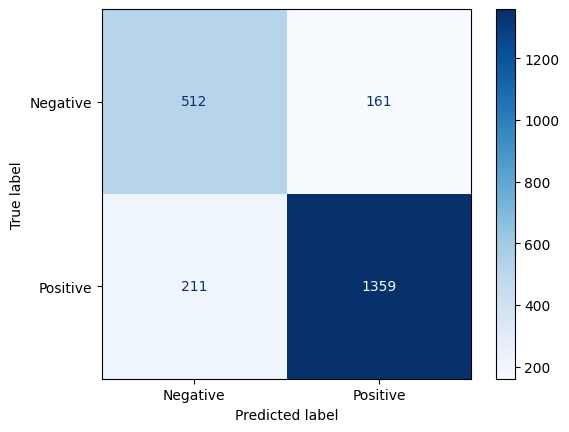

In [106]:
report = classification_report(all_true_sentiments, all_predicted_sentiments, target_names=['Negative', 'Positive'])
print(report)

cm = confusion_matrix(all_true_sentiments, all_predicted_sentiments)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')

In [107]:
count = 0

for _, row in dftest_clean.iterrows():
    if row['true_label']:
        print(f"True Label: {row['true_label']}, Predicted: {row['aspect_sentiment_map']}")
        count += 1
        if count == 20:
            break


True Label: {'purchase booking experience': 1}, Predicted: {'purchase booking experience': 1}
True Label: {'staff support': 1, 'online experience': 0, 'purchase booking experience': 1, 'value': 0}, Predicted: {'staff support': 1, 'online experience': 1, 'purchase booking experience': 1, 'value': 1}
True Label: {'company brand': 1}, Predicted: {'company brand': 0}
True Label: {'company brand': 1}, Predicted: {'company brand': 0}
True Label: {'purchase booking experience': 1, 'online experience': 1}, Predicted: {'purchase booking experience': 1, 'online experience': 1}
True Label: {'staff support': 1, 'online experience': 1, 'value': 1, 'company brand': 1}, Predicted: {'value': 1}
True Label: {'online experience': 0}, Predicted: {'online experience': 0}
True Label: {'staff support': 0, 'company brand': 0}, Predicted: {'staff support': 0, 'company brand': 0}
True Label: {'online experience': 1}, Predicted: {'online experience': 0}
True Label: {'value': 1, 'purchase booking experience': 1,